# Delivery Prediction - Model - Neural Network 
This notebook covers the following:
- Loading of preprocessed data for training the model
- Preprocessing data for neural network training
- Training a multi-layer perceptron
- Predicting accuracy of the neural network
- Displaying training and validation error

In [28]:
import pickle
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import statistics

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

In [29]:
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1

env: CUDA_VISIBLE_DEVICES=0,1


In [30]:
# Comment this code out if npz file is not being used to read in the data
data_dict_filepath = 'data/data_dict_Windows12_final.npz'
data_dict = np.load(data_dict_filepath)

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_test = data_dict['X_test']
y_test = data_dict['y_test']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Free up memory
del data_dict

X_train shape: (9131456, 239)
y_train shape: (9131456,)
X_test shape: (2282864, 239)
y_test shape: (2282864,)


#### Neural Net Preprocessing

In [31]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# print("Before Val Split X_train shape:", data_dict['X_train'].shape) # pkl file
# print("Before Val Split y_train shape:", data_dict['y_train'].shape) # pkl file
print("Before Val Split X_train shape:", X_train.shape)
print("Before Val Split y_train shape:", y_train.shape)

# Create classes in columns and OHE for each record
# train_labels = to_categorical(data_dict['y_train']) # From prepare_data
# y_test = to_categorical(data_dict['y_test']) # When using pkl file and prepare_data
train_labels = to_categorical(y_train) # From numpy file dictionary
  
X_train, X_val, y_train, y_val = train_test_split(X_train, train_labels, test_size = .25, random_state = 3)
   
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

Before Val Split X_train shape: (9131456, 239)
Before Val Split y_train shape: (9131456,)
X_train shape: (6848592, 239)
y_train shape: (6848592, 12)
X_val shape: (2282864, 239)
y_val shape: (2282864, 12)


#### MLP Model Creation and Summary

In [34]:
# Basic NN model to test potential and further need for tuning
from keras import models
from keras import optimizers
from keras import layers

model_nn = models.Sequential()
model_nn.add(layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model_nn.add(layers.Dense(512, activation = 'relu'))
# model_nn.add(layers.Dropout(0.25))
model_nn.add(layers.Dense(256, activation = 'relu'))
model_nn.add(layers.Dense(128, activation = 'relu'))
model_nn.add(layers.Dense(64, activation = 'relu'))
model_nn.add(layers.Dense(32, activation = 'relu'))
model_nn.add(layers.Dense(12, activation='softmax'))

model_nn.compile(optimizer = 'adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 1024)              245760    
_________________________________________________________________
dense_55 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_56 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_57 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_58 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_59 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_60 (Dense)             (None, 12)                396       
Total para

#### Fitting and Predicting the Model 

In [35]:
%%time
model_nn.fit(X_train, y_train, epochs=40, batch_size=1024, validation_data = (X_val, y_val))

Train on 6848592 samples, validate on 2282864 samples
Epoch 1/40
6848592/6848592 [==============================] - 49s 7us/step - loss: 1.0498 - acc: 0.6324 - val_loss: 0.9993 - val_acc: 0.6476
Epoch 2/40
6848592/6848592 [==============================] - 50s 7us/step - loss: 0.9761 - acc: 0.6570 - val_loss: 0.9747 - val_acc: 0.6589
Epoch 3/40
6848592/6848592 [==============================] - 50s 7us/step - loss: 0.9463 - acc: 0.6683 - val_loss: 0.9482 - val_acc: 0.6689
Epoch 4/40
6848592/6848592 [==============================] - 49s 7us/step - loss: 0.9260 - acc: 0.6760 - val_loss: 0.9373 - val_acc: 0.6732
Epoch 5/40
6848592/6848592 [==============================] - 49s 7us/step - loss: 0.9108 - acc: 0.6811 - val_loss: 0.9291 - val_acc: 0.6765
Epoch 6/40
6848592/6848592 [==============================] - 49s 7us/step - loss: 0.8987 - acc: 0.6854 - val_loss: 0.9275 - val_acc: 0.6775
Epoch 7/40
6848592/6848592 [==============================] - 50s 7us/step - loss: 0.8885 - acc: 0.6

In [40]:
# Predict
y_pred_nn = model_nn.predict(X_test)
y_pred_classes = model_nn.predict_classes(X_test)

In [39]:
def calc_accuracy_windows(max_windows, y_test, y_pred):

    # Initialize array to hold counts for each window
    count_arr = np.zeros(max_windows)

    # For each class window, if predicted class is in window, increment count 
    # E.g. if predicted class = 4 and target class = 6, since max window allowed = 2, consider instance as accurate and increment count 
    for idx, value in enumerate(y_test):
        for window in np.arange(1,max_windows+1): 
             # window_arr calculates window that predicted value can fall into 
             # e.g. target value = 4, window = 2, window_arr = {2,3,4,5,6}
             window_arr = np.arange(value - window, value + window + 1)
             if (y_pred[idx] in window_arr):
                count_arr[window-1] += 1

    # Print accuracy for each time window     
    accuracy_list = []
    print("Accuracy with +- 0 time window(s): ", accuracy_score(y_test, y_pred)*100)
    accuracy_list.append(accuracy_score(y_test, y_pred))
    for idx, count in enumerate(count_arr):
        print("Accuracy with +- ", idx, " time window(s): ", (count/len(y_pred))*100)   
        accuracy_list.append(count/len(y_pred))
    
    return accuracy_list

In [41]:
y_preds = []
for row in y_pred_nn:
    max_row_idx = row.argmax()
    y_preds.append(max_row_idx)
    
print(len(y_preds))
print(len(y_pred_nn))

# accuracy_nn = calc_accuracy_windows(2, data_dict['y_test'], y_preds) # When using pkl file
accuracy_nn = calc_accuracy_windows(2, y_test, y_preds) # When using npz file

2282864
2282864
Accuracy with +- 0 time window(s):  69.11511154409548
Accuracy with +-  0  time window(s):  87.37174005985464
Accuracy with +-  1  time window(s):  94.82518450507783


#### Displaying Training Loss and Error

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
'''
Defining methods that will be frequently used for model
training and tuning.
'''

def loss_curve_plot(model):
    model_nn_hist_dict = model.history.history

    acc = model.history.history['acc']
    val_acc = model.history.history['val_acc']
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.clf()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def acc_curve_plot(model):
    model_nn_hist_dict = model.history.history

    acc = model.history.history['acc']
    val_acc = model.history.history['val_acc']
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    plt.clf()   # clear figure
    acc_values = model_nn_hist_dict['acc']
    val_acc_values = model_nn_hist_dict['val_acc']

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

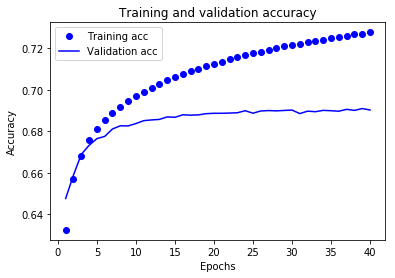

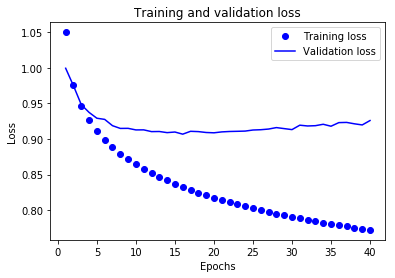

In [43]:
model_nn_acc_curve = acc_curve_plot(model_nn)
model_nn_loss_curve = loss_curve_plot(model_nn)